In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### File reading

          0         1         2
0  0.912742  1.719443  1.606405
1  0.313207  1.769782  1.628300
2  1.423678 -0.713694 -0.594431
3 -0.066379  2.153243  1.963148
4  1.036332  0.658611  0.642875


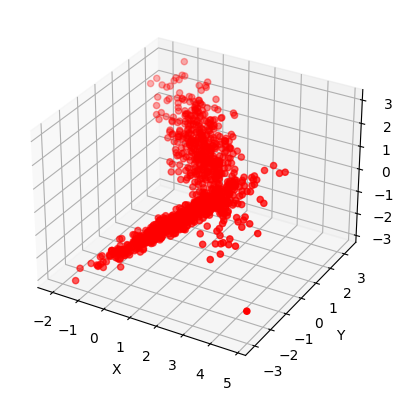

In [15]:
# read txt file
file = pd.read_csv('alvbercau_alvgonfri_dataset.txt', sep=" ", header=None)

# convert to dataframe in order to use pandas methods if needed
df = pd.DataFrame(file)

# show the first 5 rows
print(df.head())

# visualize the data with a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0], df[1], df[2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# convert dataframe to numpy array
X = df.values


### K-means

In [23]:
def kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
    labels = kmeans.predict(data)
    return labels

### Clustering method

In [24]:
def clustering(data, algorithm, hyperparameters):
    if algorithm == 'kmeans':
        return kmeans(data, hyperparameters.get('n_clusters'))        
    else:
        print("Not valid algorithm")

labels = clustering(X, 'kmeans', {'n_clusters': 3})
print(labels)

[0 0 1 0 1 1 1 1 2 1 2 0 2 2 2 0 0 0 1 2 0 1 2 2 1 0 0 2 0 0 2 0 1 1 1 1 1
 2 0 1 1 1 0 1 1 2 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 0 1 0 2 2 2 0 0 1 2 2
 2 0 1 0 0 1 0 0 0 1 1 0 2 2 1 2 0 2 0 2 2 1 1 0 0 0 1 2 1 1 0 1 0 2 0 2 1
 0 2 1 1 1 0 2 0 2 0 1 1 1 1 0 1 2 1 2 1 1 1 1 2 2 1 2 0 0 0 2 0 2 2 1 0 2
 1 1 2 2 0 0 2 1 2 1 2 1 1 2 0 1 0 1 2 1 1 1 2 2 1 2 0 2 2 0 2 1 2 0 1 2 1
 2 0 1 1 0 1 0 0 1 2 2 2 0 1 0 0 0 0 2 2 0 1 1 0 2 2 1 0 2 2 1 1 0 2 2 1 2
 0 1 2 1 2 1 1 1 1 0 1 1 2 0 0 0 1 2 0 0 2 2 2 1 1 1 1 1 0 0 1 0 1 1 2 0 0
 0 1 1 0 2 0 2 1 2 0 1 2 1 2 2 2 1 1 0 1 0 2 1 0 2 0 1 0 2 0 1 1 1 2 1 1 2
 2 2 0 2 1 1 0 1 1 2 1 2 0 0 1 1 2 2 1 2 1 1 1 2 2 0 1 2 0 1 0 2 1 2 0 2 1
 0 1 2 2 1 1 0 2 1 2 1 1 1 2 0 1 0 1 1 2 1 1 1 1 0 2 0 1 1 1 0 0 1 1 1 0 2
 2 1 2 1 1 2 2 0 1 1 1 2 0 1 1 0 2 0 1 2 2 1 2 1 2 2 0 0 1 1 1 2 1 1 0 1 1
 0 1 2 0 2 0 0 1 0 1 0 2 1 1 1 2 1 0 2 1 0 0 1 1 0 2 2 2 1 0 1 0 1 2 1 0 2
 2 2 0 2 1 1 0 2 0 2 0 0 2 2 2 1 0 0 1 0 2 2 0 0 2 1 1 2 2 2 1 0 0 1 1 1 0
 2 2 2 0 2 2 2 1 2 2 0 1 

### K-Means

          0         1         2
0  0.912742  1.719443  1.606405
1  0.313207  1.769782  1.628300
2  1.423678 -0.713694 -0.594431
3 -0.066379  2.153243  1.963148
4  1.036332  0.658611  0.642875
coordinate: [0.91274243 1.71944335 1.6064054 ] label: 0
coordinate: [0.31320654 1.7697818  1.62830007] label: 0
coordinate: [ 1.42367768 -0.71369375 -0.59443123] label: 1
coordinate: [-0.06637929  2.15324284  1.96314798] label: 0
coordinate: [1.03633188 0.65861141 0.64287462] label: 1
coordinate: [ 4.00654918 -0.68307969 -0.46281996] label: 1
coordinate: [ 1.72505491 -0.40304943 -0.2987316 ] label: 1
coordinate: [3.05388838 0.64528482 0.7116815 ] label: 1
coordinate: [ 0.34308874 -1.32592215 -1.19673651] label: 2
coordinate: [1.72502646 0.69204534 0.70103862] label: 1
coordinate: [ 0.39245338 -1.66365824 -1.50309287] label: 2
coordinate: [0.51469554 1.20611391 1.12178375] label: 0
coordinate: [ 0.34445267 -1.51628726 -1.3704764 ] label: 2
coordinate: [ 0.29852545 -1.58566581 -1.4356591 ] label: 2


c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


coordinate: [-0.13314568 -2.11600322 -1.93715773] label: 2
coordinate: [-1.0973723   2.97131653  2.66863348] label: 0
coordinate: [1.29136094 0.53559885 0.54080523] label: 1
coordinate: [1.08655967 1.42522572 1.34477423] label: 0
coordinate: [0.44799807 1.87975194 1.73410755] label: 0
coordinate: [ 2.51362551 -0.14580186 -0.03222753] label: 1
coordinate: [-0.08639413  0.93445934  0.84965119] label: 0
coordinate: [0.12956583 0.32168288 0.29888178] label: 0
coordinate: [-1.2724169   2.86000641  2.55998713] label: 0
coordinate: [1.39243809 0.56008874 0.56722005] label: 1
coordinate: [ 1.84393174 -0.33170343 -0.22882491] label: 1
coordinate: [0.81033728 1.7691218  1.64764957] label: 0
coordinate: [ 1.21959097 -0.83383299 -0.71230375] label: 2
coordinate: [ 1.02804376 -0.99426301 -0.86645665] label: 2
coordinate: [ 2.1475098  -0.30499377 -0.19225629] label: 1
coordinate: [ 1.02919568 -1.02335137 -0.89296675] label: 2
coordinate: [0.02443782 1.382084   1.26276018] label: 0
coordinate: [ 1.06

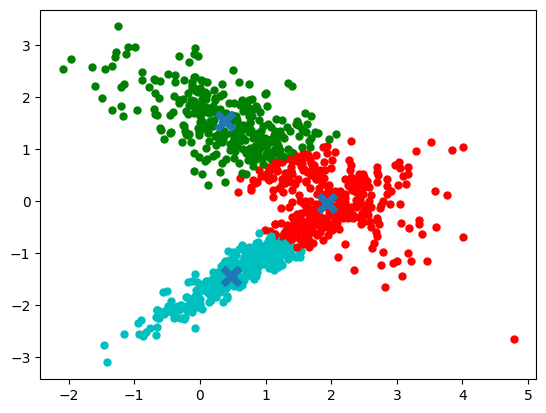

In [21]:
#K-Means

# read a txt file
data = pd.read_csv('alvbercau_alvgonfri_dataset.txt', sep=" ", header=None)

# convert to data todataframe
df = pd.DataFrame(data)

# show the first 5 rows
print(df.head())

X = df.values

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

colors = ["g.","r.","c.","y.","m."]

for i in range(len(X)):
    print("coordinate:",X[i], "label:", labels[i])
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 10)

plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()